# Morphological metrics for 3D volumetric ductal structures

This is a companion code of the paper:

*Homological features of airway tree on computed tomography and longitudinal change in lung function in patients with chronic obstructive pulmonary disease*

by Naoya Tanabe, Shizuo Kaji (equal contribution), Susumu Sato, Tomoki Maetani, Yusuke Shiraishi, Tsuyoshi Oguma, Ryo Sakamoto, Motonari Fukui, Shigeo Muro, Toyohiro Hirai

In [1]:
# execute this cell for setting up the environment
# (it is required only for the first run)
!pip install -U git+https://github.com/shizuo-kaji/CubicalRipser_3dim
!pip install scikit-fmm pynrrd persim


  Cloning https://github.com/shizuo-kaji/CubicalRipser_3dim to /tmp/pip-req-build-t7egs_cv
  Running command git clone --filter=blob:none --quiet https://github.com/shizuo-kaji/CubicalRipser_3dim /tmp/pip-req-build-t7egs_cv
  Resolved https://github.com/shizuo-kaji/CubicalRipser_3dim to commit 24dc821107dc76f93ca66cad208dd278cd94bb21
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cripser: filename=cripser-0.0.8-cp39-cp39-linux_x86_64.whl size=138358 sha256=25f3f948c17261de6df82b5aa64bb7a05a4376e6e6c605bc2367e307998e92a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-b8jr77t0/wheels/48/20/b5/0e060f711f5cb3c8e41473f2eb5919be9d2c06a6ef3cc8f7f3
Successfully built cripser
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.3/432.3 kB 6.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirement

## Computation of metrics

In [15]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
import nrrd
import skfmm
import numpy as np
import cripser,tcripser
import pandas as pd
import os, zipfile, io, re, glob,pprint
import seaborn as sns
from tqdm.notebook import tqdm
import persim
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import pearsonr, spearmanr, entropy
import queue

# a variant of flood fill diffusing only to ascending neighbours
def ascending_flood(img,seed_point,tol=0, lo=-1000, high=1000):
    q = queue.Queue()
    q.put(tuple(seed_point)) # elements in the queue are tuples
    neighbours = [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]
    tovisit = np.logical_and(img>=lo, img<=high)
    #print(tovisit.sum())
    mask = np.zeros(img.shape,dtype=bool)
    while not q.empty():
        p = q.get()
        for v in neighbours:
            nextp = tuple(np.array(p)+np.array(v))
            if 0 <= nextp[0] < img.shape[0] and 0 <= nextp[1] < img.shape[1] and 0 <= nextp[2] < img.shape[2]:
                #print(p,nextp,tovisit[nextp],mask[nextp])
                if tovisit[nextp] and not mask[nextp] and img[nextp] >= img[p]+tol:
                    #print(nextp,tovisit[nextp],tovisit.shape)
                    tovisit[nextp] = False
                    mask[nextp] = True
                    q.put(nextp)
    return(mask)


In [10]:
# configulation

modes = ["tree","radial"]

## volume data (3d numpy array): need not be in the nrrd format
## Note: for generation-wise analysis, prepare volume data for each range of generations.

volume_fn = "test.nrrd"
volume, header = nrrd.read(volume_fn, index_order='C')

## binarisation threshold
threshold = -2000
binarised_volume = (volume>threshold)

## coordinates of the origin (z,y,x) for "tree"; the point must lie inside the ductal structure
origin = (110,185,173)
if binarised_volume[origin]==0:
    print("The origin must lie inside the ductal structure! Choose the right point.")

## number of bins for PH metrics
num_bins = {"tree": 5, "radial": 3}
min_life = {"tree": 1, "radial": 1}
max_life = {"tree": None, "radial": 6}

## skelton for "radial" in 3d binary numpy array
skeleton = skeletonize(binarised_volume)


In [9]:
# compute the signed distance from the origin
roi = np.ones(volume.shape)
roi[origin] = 0
dist_vol = {"tree": (-skfmm.distance(np.ma.MaskedArray(roi,~binarised_volume))).filled(fill_value=0),
            "radial": (-skfmm.distance(np.ma.MaskedArray(~skeleton,~binarised_volume))).filled(fill_value=0)}


In [11]:
# PH computation: takes time
res = dict()
H = dict()
for mode in tqdm(modes):
    PH = cripser.computePH(dist_vol[mode], maxdim=0)
    PH = PH[np.logical_and(PH[:,0]==0,PH[:,2]<PH[:,2].max())] # remove permanent cycles
    life = np.abs(PH[:,2] - PH[:,1])
    birth = np.abs(PH[:,1])
    if max_life[mode] is None:
        max_life[mode] = np.percentile(life,100)
    PH_entropy = entropy(life, base=2) # / np.log2(sum(life))
    life_hist, life_bin = np.histogram(life,bins=num_bins[mode], range=(min_life[mode],max_life[mode]))
    birth_hist, birth_bin = np.histogram(birth,bins=num_bins[mode], range=(min_life[mode],max_life[mode]))
    H[mode] = PH
    res[f"{mode}H_entropy"] = PH_entropy
    for i,x in enumerate(life_hist):
        res[f"{mode}H_L{i}"] = life_hist[i]
    for i,x in enumerate(life_bin):
        res[f"{mode}_Lbin{i}"] = life_bin[i]        
    for i,x in enumerate(birth_hist):
        res[f"{mode}H_B{i}"] = birth_hist[i]
    for i,x in enumerate(birth_bin):
        res[f"{mode}_Bbin{i}"] = birth_bin[i]        


  0%|          | 0/2 [00:00<?, ?it/s]

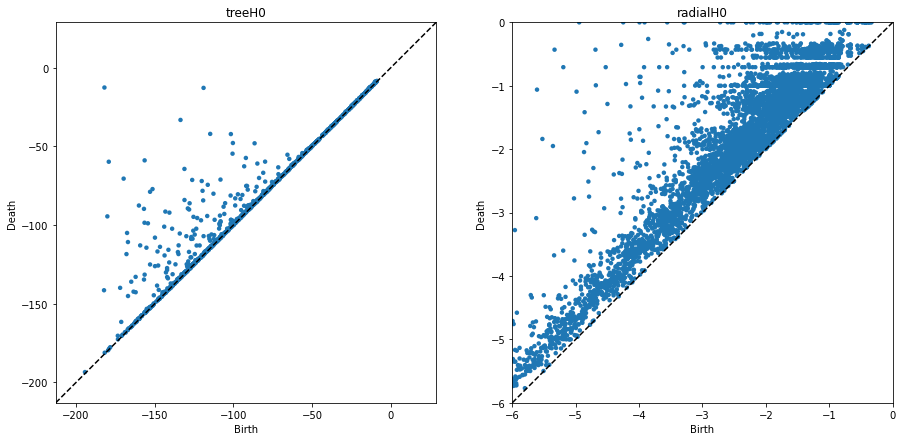

In [12]:
## plot persistence diagram
fig, ax= plt.subplots(1,2,figsize=(15,8))
persim.plot_diagrams((H["tree"][:,1:3]),legend=False, lifetime=False, ax=ax[0],title="treeH0")
persim.plot_diagrams((H["radial"][:,1:3]),xy_range=(-max_life["radial"],0,-max_life["radial"],0), legend=False, lifetime=False, ax=ax[1],title="radialH0")


In [17]:
# metrics
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(res)

{   'radialH_B0': 5676,
    'radialH_B1': 1310,
    'radialH_B2': 496,
    'radialH_L0': 674,
    'radialH_L1': 37,
    'radialH_L2': 8,
    'radialH_entropy': 12.906056545992877,
    'radial_Bbin0': 1.0,
    'radial_Bbin1': 2.666666666666667,
    'radial_Bbin2': 4.333333333333334,
    'radial_Bbin3': 6.0,
    'radial_Lbin0': 1.0,
    'radial_Lbin1': 2.666666666666667,
    'radial_Lbin2': 4.333333333333334,
    'radial_Lbin3': 6.0,
    'treeH_B0': 219,
    'treeH_B1': 233,
    'treeH_B2': 373,
    'treeH_B3': 389,
    'treeH_B4': 171,
    'treeH_L0': 160,
    'treeH_L1': 30,
    'treeH_L2': 8,
    'treeH_L3': 2,
    'treeH_L4': 1,
    'treeH_entropy': 7.468884078383945,
    'tree_Bbin0': 1.0,
    'tree_Bbin1': 34.686233859026046,
    'tree_Bbin2': 68.37246771805209,
    'tree_Bbin3': 102.05870157707814,
    'tree_Bbin4': 135.74493543610419,
    'tree_Bbin5': 169.43116929513022,
    'tree_Lbin0': 1.0,
    'tree_Lbin1': 34.686233859026046,
    'tree_Lbin2': 68.37246771805209,
    'tree_L

## create a volume containing labels for PH cycles

use ITK-snap for visualisation: load the original CT as the main volume and the output of this as segmentation

http://www.itksnap.org/pmwiki/pmwiki.php


In [18]:
## annotation type
#annot_type = 'line'
annot_type = 'fill'
mode = "tree"
cls = "life"

# print information
verbosity = 0


In [19]:
# output filename
outfn = os.path.splitext(volume_fn)[0]+f'_{mode}_{cls}_{annot_type}.nrrd'

out = binarised_volume.copy().astype(np.uint8)

# label classes
char_cycles = []
for i in range(num_bins[mode]):
    if cls == "birth":
        char_cycles.append({'dim':0, 'b0':-res[f"{mode}_Bbin{i+1}"], 'b1':-res[f"{mode}_Bbin{i}"], 'l0':min_life[mode], 'l1':max_life[mode], 'col': i+2 })
    else:
        char_cycles.append({'dim':0, 'l0':res[f"{mode}_Lbin{i}"], 'l1':res[f"{mode}_Lbin{i+1}"], 'b0':-max_life[mode], 'b1':-min_life[mode], 'col': i+2 })

# counter for each label
cnt = np.zeros(len(char_cycles))

# normalising by the maximum birth/life values
for i,p in tqdm(enumerate(H[mode]), total=len(H[mode])):
    # iterate over PH cycles
    for j,cc in enumerate(char_cycles):
        d,b0,b1,l0,l1 = cc['dim'],cc['b0'],cc['b1'],cc['l0'],cc['l1']
        if p[0]==d and (l1>=p[2]-p[1]>=l0) and (b1>=p[1]>=b0):
            bx,by,bz = p[3:6].astype(np.int32)
            dx,dy,dz = p[6:9].astype(np.int32)
            sp = (bx,by,bz)
            if verbosity > 1:
                print("birth (z,y,x)=",sp,"death (z,y,x)=",dx,dy,dz, "birth%, life%=",b, life)
            cnt[j] += 1
            if annot_type == 'fill':
                mask = ascending_flood(dist_vol[mode], seed_point=sp, lo=p[1], high=p[2], tol=0.1)
                out[mask] =  cc['col']
                if verbosity > 0:
                    print(p[1],p[2],dist_vol[mode][sp], mask.sum(),volume[sp])
            elif annot_type == 'line':
                lin = line_nd((sp), (dx,dy,dz), endpoint=False)
                out[lin] = cc['col']
print(f'cycle counts: ',cnt)
print(f'label counts: ',[(out==i).sum() for i in range(len(char_cycles)+2)])
nrrd.write(outfn, out, index_order='C')
print(f'successfully created {outfn}')


  0%|          | 0/1401 [00:00<?, ?it/s]

cycle counts:  [157.  29.   6.   1.   0.]
label counts:  [38725566, 75925, 6931, 11012, 5386, 7680, 0]
successfully created test_tree_life_fill.nrrd


# Utility

In [ ]:
# check the volume
import ipyvolume as ipv
ipv.quickvolshow(binarised_volume, data_min=0, data_max=1)


In [ ]:
# check the skeleton
ipv.quickvolshow(skeleton, data_min=0, data_max=1)

In [ ]:
# check distance transform
ipv.quickvolshow(dist_vol["tree"], data_min=0, data_max=1)

In [21]:
# write to file for debugging
nrrd.write("radial_dist.nrrd", dist_vol["radial"], index_order='C')
nrrd.write("geodesic_dist.nrrd", dist_vol["tree"], index_order='C')
